## 패키지 임포트

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


## 데이터 불러와서 시계열 데이터로
- ndivia 주식 데이터

In [118]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NVDA.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
ts = df['Close']

In [119]:
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-17    149.059998
2021-02-18    148.289993
2021-02-19    149.264999
2021-02-22    143.557495
2021-02-23    141.419998
Name: Close, dtype: float64

### 결측치는 time 기준으로 보간하고, 결측치가 있는지 파악

In [120]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 데이터 확인

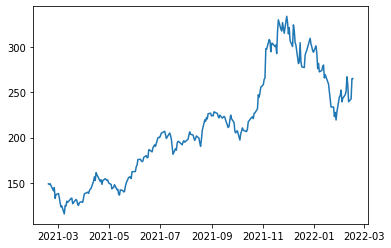

In [121]:
plt.plot(ts)

### 로그화

In [122]:
ts_log = np.log(ts)

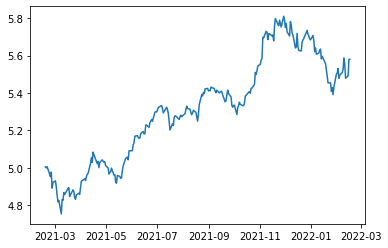

In [123]:
plt.plot(ts_log)

### 이동평균 구하는 함수 정의

In [32]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

### ADF Test 수행하는 코드

In [33]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 ADF test
- 시계열 분해

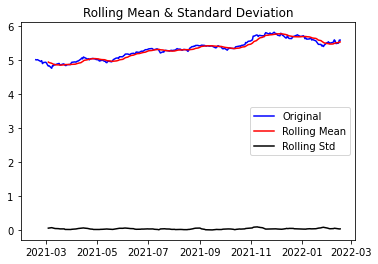

Results of Dickey-Fuller Test:
Test Statistic                  -1.433994
p-value                          0.565875
#Lags Used                       6.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


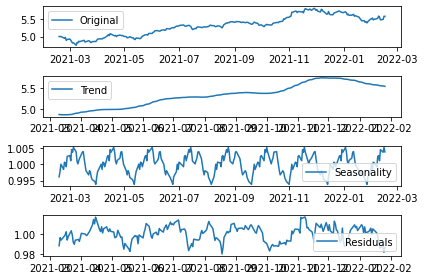

In [124]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [125]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.770108
p-value                          0.000062
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


- p-value가 많이 낮아진걸로 보아서 시계열 데이터로 봐도 무방한듯 하다.

### 학습, 테스트 데이터셋 생성

Date
2021-02-17    5.004349
2021-02-18    4.999170
Name: Close, dtype: float64
(203,)
(51,)


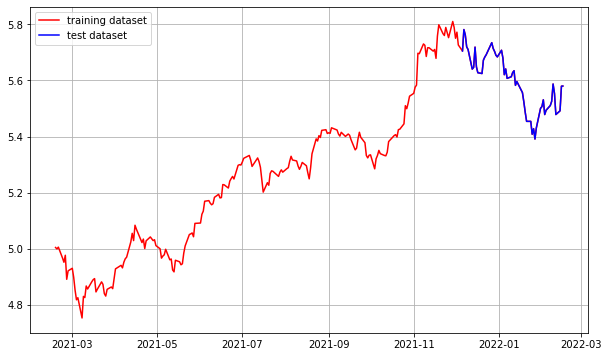

In [126]:
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

### 적정 ARIMA 모수 찾기

- p, q 값

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


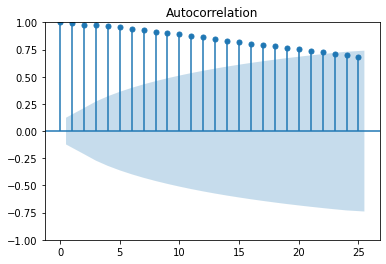

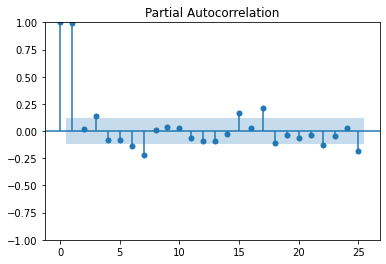

In [127]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF 그래프는 점차 감소하는 추세를 보이고 AR(1) 모델에 유사한 형태를 보이므로, q에 대해서는 적합한 값이 없어 보인다.  
PACF 그래프는 2 이후에 0에 가까우니 p=1이상이 적합

- d 값

Results of Dickey-Fuller Test:
Test Statistic                  -5.267741
p-value                          0.000006
#Lags Used                       5.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


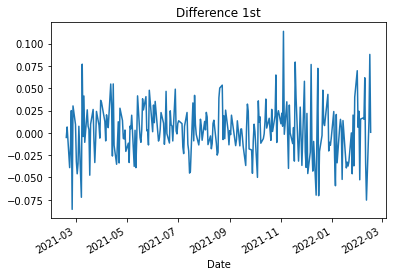

In [128]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.007671e+00
p-value                        2.244862e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


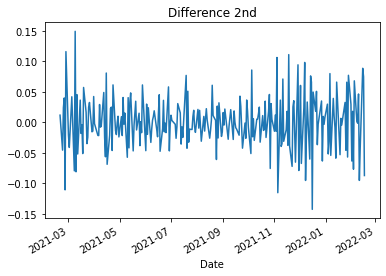

In [129]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차분의 p-value가 더 적으니 d=2로 해보자

### ARIMA 모델  훈련 및 테스트

In [132]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  203
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 441.245
Date:                Thu, 17 Feb 2022   AIC                           -872.491
Time:                        14:19:02   BIC                           -855.925
Sample:                             0   HQIC                          -865.789
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3324      0.296     17.989      0.000       4.751       5.913
ar.L1          0.0767      0.578      0.133      0.894      -1.055       1.209
ar.L2          0.9169      0.571      1.605      0.1

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


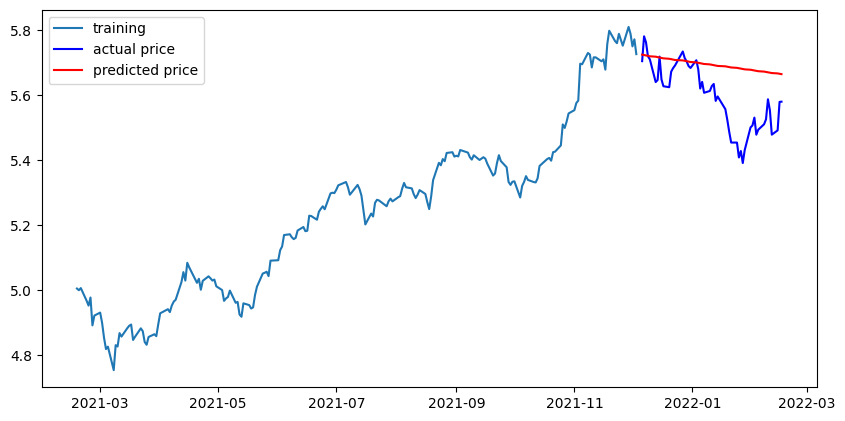

In [133]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 결과 분석

In [50]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1214.550717859296
MAE:  28.099508224536102
RMSE:  34.85040484498417
MAPE: 11.23%


### Tesla 데이터로 한번더 작업

In [51]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/TSLA.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
ts = df['Close']

In [52]:
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
2021-02-23    698.840027
Name: Close, dtype: float64

In [53]:
ts=ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

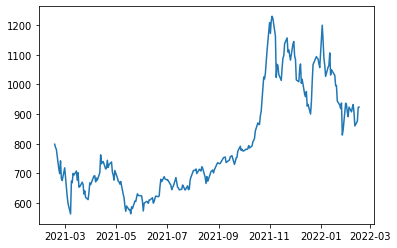

In [54]:
plt.plot(ts)

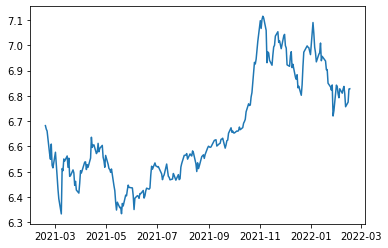

In [56]:
ts_log = np.log(ts)
plt.plot(ts_log)

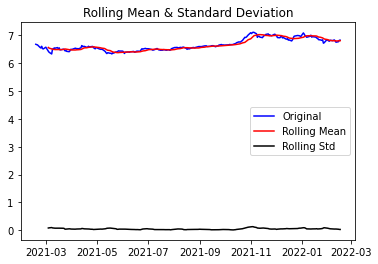

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


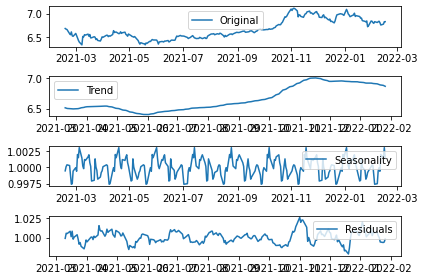

In [57]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [58]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


Date
2021-02-17    6.682297
2021-02-18    6.668711
Name: Close, dtype: float64
(203,)
(51,)


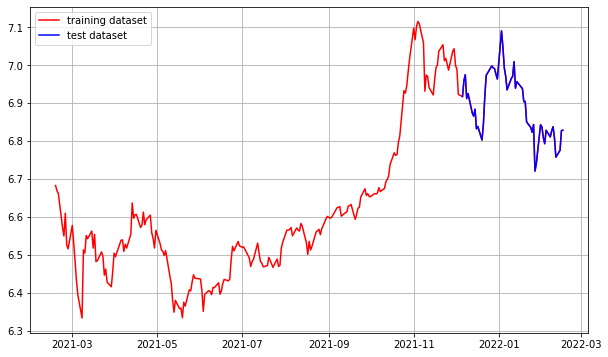

In [59]:
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


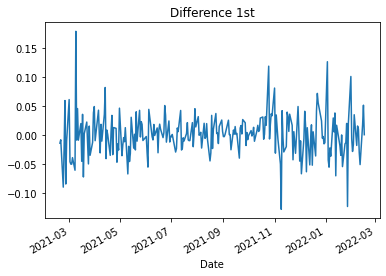

In [62]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


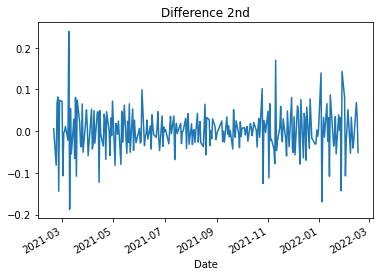

In [63]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### p,q,d를 자동적으로 확인해주는 함수를 써보자

In [76]:
model = pm.auto_arima(y = ts_log        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 10   
                      , start_q = 0 
                      , max_q = 10   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-767.252, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-843.473, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-769.251, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-882.032, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-895.089, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-902.277, Time=0.42 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-915.021, Time=0.57 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=-921.645, Time=0.85 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=-919.650, Time=1.14 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=-923.007, Time=1.40 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-927.450, Time=1.36 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-940.071, Time=1.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-939.979, Time=0.42 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : 

In [77]:
# Build and Train  Model
model = ARIMA(train_data, order=(4, 2, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  203
Model:                 ARIMA(4, 2, 1)   Log Likelihood                 394.013
Date:                Thu, 17 Feb 2022   AIC                           -776.026
Time:                        13:53:15   BIC                           -756.206
Sample:                             0   HQIC                          -768.006
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0664      0.072     -0.922      0.356      -0.207       0.075
ar.L2          0.0427      0.072      0.592      0.554      -0.099       0.184
ar.L3          0.0737      0.090      0.819      0.4

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


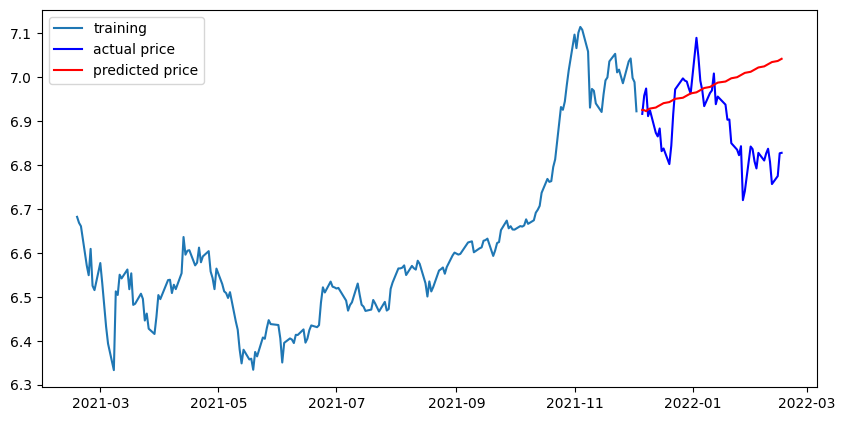

In [78]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [79]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  19644.502767726906
MAE:  110.29191317448351
RMSE:  140.15884833904317
MAPE: 11.85%


### auto_arima가 적당히 동작은 하는것 같다! 다음 데이터 셋에서 1년을 학습하고 다음년도를 예측해보자

In [95]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMZN2020.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
ts_train = df['Close']

In [96]:
ts_train_log = np.log(ts_train)

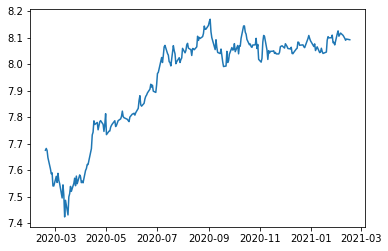

In [97]:
plt.plot(ts_train_log)

In [98]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMZN2021.csv' 
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
ts_test = df2['Close']

In [99]:
ts_test_log = np.log(ts_test)

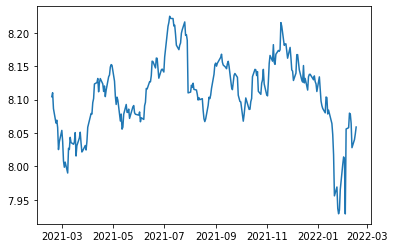

In [100]:
plt.plot(ts_test_log)

- train 데이터 분석 및 시계열 분해

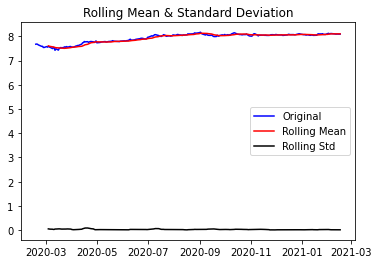

Results of Dickey-Fuller Test:
Test Statistic                  -1.164884
p-value                          0.688516
#Lags Used                       1.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


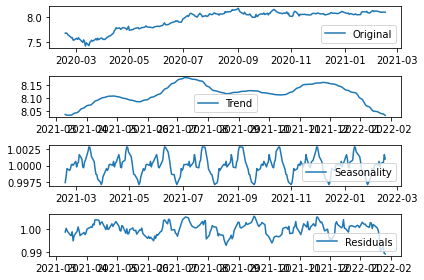

In [101]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_train_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_train_log)

#시계열 분해 (Time Series Decomposition)
train_decomposition = seasonal_decompose(ts_train_log, model='multiplicative', period = 30) 

train_trend = decomposition.trend
train_seasonal = decomposition.seasonal
train_residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(train_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(train_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(train_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [102]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(train_residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.879279
p-value                          0.002193
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


- test 데이터 분석 및 시계열 분해

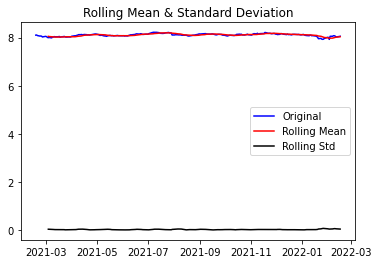

Results of Dickey-Fuller Test:
Test Statistic                  -2.563007
p-value                          0.100886
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


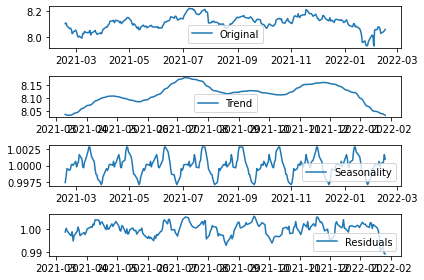

In [106]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_test_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_test_log)

#시계열 분해 (Time Series Decomposition)
test_decomposition = seasonal_decompose(ts_test_log, model='multiplicative', period = 30) 

test_trend = decomposition.trend
test_seasonal = decomposition.seasonal
test_residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_test_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(test_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(test_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(test_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [107]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(test_residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.879279
p-value                          0.002193
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


Date
2021-02-17    6.682297
2021-02-18    6.668711
Name: Close, dtype: float64
(252,)
(254,)


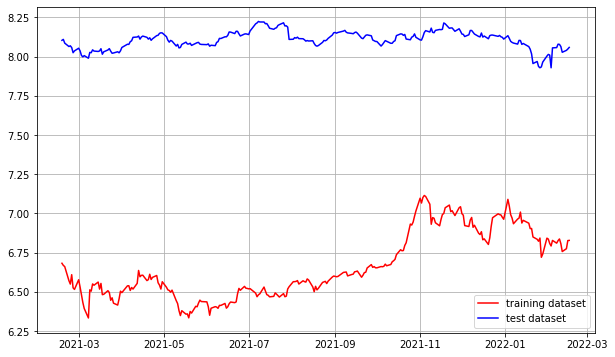

In [108]:
train_data = ts_train_log
test_data = ts_test_log
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


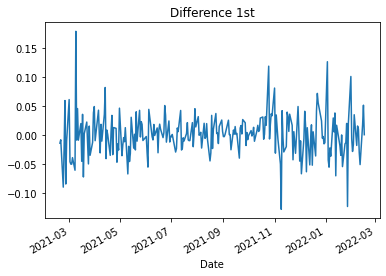

In [109]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


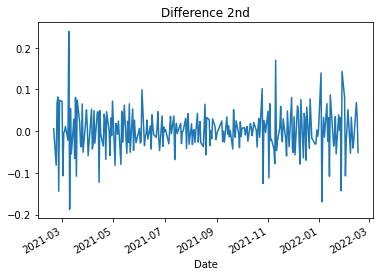

In [110]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [111]:
model = pm.auto_arima(y = ts_train_log        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 10   
                      , start_q = 0 
                      , max_q = 10   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-939.810, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1045.770, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-941.809, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1065.629, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-1083.943, Time=0.19 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-1098.070, Time=0.49 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-1098.712, Time=0.63 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=-1113.378, Time=0.65 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=-1111.709, Time=0.73 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=-1126.284, Time=1.60 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-1128.168, Time=1.40 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-1130.882, Time=1.14 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-1133.664, Time=0.75 sec
 ARIMA(2,2,1)(0,0,0)[0] int

### auto_arima를 사용해봤지만, 아직 어떻게 사용하지는지 정확하게 몰라서 오히려 예측 결과가 낮아지는 경향이 있었다.
- p+q < 2, p * q = 0의 공식에 따라서 최적의 값을 찾아보았다.

In [115]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  252
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 580.806
Date:                Thu, 17 Feb 2022   AIC                          -1151.612
Time:                        14:11:49   BIC                          -1133.964
Sample:                             0   HQIC                         -1144.511
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9333      0.104     76.327      0.000       7.730       8.137
ar.L1          0.4192      0.249      1.683      0.092      -0.069       0.907
ar.L2          0.5669      0.247      2.297      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


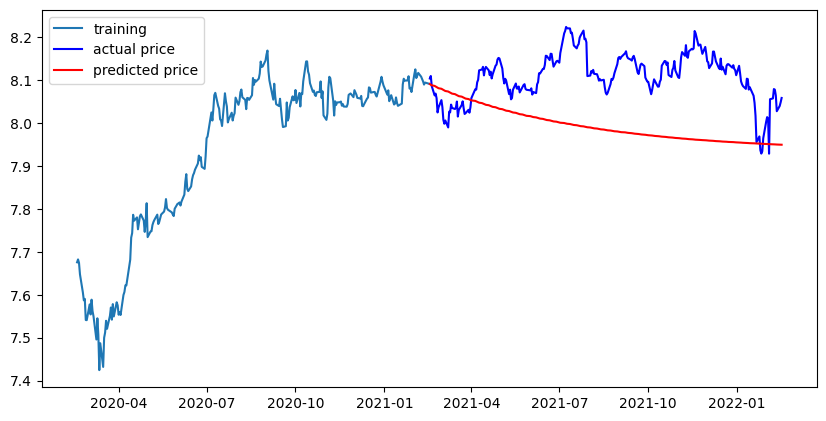

In [116]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [117]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  185313.04388654625
MAE:  381.55782811303266
RMSE:  430.4800156645442
MAPE: 11.21%


## 회고
- 이번 EX는 주식 결과를 예측하는 모델을 만드는 과제였다.
- 주식이란 시장이 단순히 주가의 가격만가지고 예측하기엔 힘들겠지만, 주가만 가지고 예측하다고 가정을 하였다.  시계열 데이터라는걸 처음 접했던 과제였는데, 아무래도 처음 접한 개념이 많다보니 lms를 따라가기에도 벅찼다.   그래도 과정대로 따라가다보면 결과를 얻을 수 있었다.


- 두번째 데이터에서 auto_arima라는 함수를 발견해서 적용을 해보았다, 이전 학습 모델에서 적용했던 random serach나 grid search가 떠오르는 함수였다.  
그대로 세번째 데이터때도 사용을 해봤지만, 역시 제대로 함수를 알지 못하고 사용해서 그런지 MAPE 수치가 오히려 28% 대가 나오고, lms에서 배운 대로 적용을 해보니 다행이 수치가 떨어졌다.  

- 시계열도 매력적인 데이터이지만, 함수를 사용하려면 정확하게 알고 사용해야한다는 교훈을 얻은 익스였다.